# Node Classification with Graph Neural Networks

In this project, I will be implementing a GNN model to classify nodes in the Amazon Computers dataset. The Amazon Computers dataset was first introduced in [Shchur et al., 2019](https://arxiv.org/abs/1811.05868) titled <i>Pitfalls of Graph Neural Network Evaluation</i>. The dataset is a segment of the Amazon co-purchase graph [McAuley et al., 2015](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf), where nodes represent goods, edges indicate that two goods are frequently bought together, node features are bag-of-words encoded product reviews, and class labels are given by the product category.

First, I try a simple MLP model with 3 Linear Layers, which uses only feature embeddings to predict class labels. The model continues to train until around 150 epochs where it begins overfitting. At this point, the ROC AUC is roughly 0.55. Then I try a GNN model with 3 GCNConv Layers. The model continues to train until around 1,500 epochs before it tarts overfitting and achieves a ROC AUC of around 0.76. The difference in model performance shows that the model was able to take advantage of the available information in the edge features, which allowed it to train for longer without overfitting and achieve much better performance.

In [1]:
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
import random
import torch
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

In [2]:
dataset = Amazon(root='data/Amazon',name='computers', transform=NormalizeFeatures())

In [3]:
print()
print(f'Dataset: {dataset}')
print('===========')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset.data
# this dataset is not split into a training and a test set, so I randomly split the dataset into 20% train and 80% test
# setting the random seed so that the train and test set are always the same
random.seed(0)
data.train_mask = torch.tensor([False if random.random() < 0.8 else True for num in range(data.num_nodes)])
data.test_mask = torch.tensor([False if num == True else True for num in data.train_mask])

print()
print(data)
print('===========')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: AmazonComputers()
Number of graphs: 1
Number of features: 767
Number of classes: 10

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], train_mask=[13752], test_mask=[13752])
Number of nodes: 13752
Number of edges: 491722
Average node degree: 35.76
Number of training nodes: 2712
Training node label rate: 0.20
Has isolated nodes: True
Has self-loops: False
Is undirected: True


Above, I can see that there are 13,752 nodes and 491,722 edges which results in an average node degree of 35.8. The graph is undirected and isolated nodes do exist. I split my data into a 20% training set and an 80% test set.

Also, I made use of data transformations via transform=NormalizeFeatures(). This resulted in row-normalizing the input feature vectors. In other words, the features in each row sum up to 1.

In [4]:
# the training mask is boolean True/False
data.train_mask

tensor([ True, False, False,  ...,  True, False,  True])

In [5]:
values, counts = np.unique(data.y[data.train_mask].numpy(), return_counts=True)
print("value\tcount")
for val, count in zip(values, counts):
    print(f"{val}\t{count}")

value	count
0	81
1	433
2	278
3	102
4	1030
5	67
6	97
7	140
8	416
9	68


In [6]:
print(f"Percentage of label '4' in the full dataset: {round(counts[4]/sum(counts),2)}")
print(f"Percentage of top 3 most common labels in the full dataset: {round((counts[1]+counts[4]+counts[8])/sum(counts),2)}")

Percentage of label '4' in the full dataset: 0.38
Percentage of top 3 most common labels in the full dataset: 0.69


Here I can see that the most common value by far is 4, consisting of 38% of the dataset. This is an unbalanced classification task, so I'm going to use a different metric to evaluate performance other than accuracy. I'm going to use the AUC ROC metric. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is.

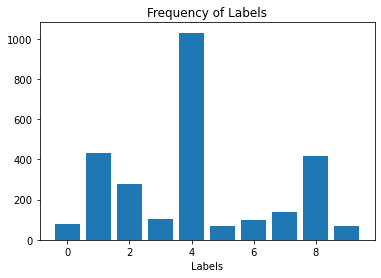

In [7]:
import matplotlib.pyplot as plt
plt.bar(height=counts, x=values)
plt.title("Frequency of Labels")
plt.xlabel("Labels")
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
# move data to gpu for gpu acceleration
data = data.to(device)
data.is_cuda

True

## Training a Multi-layer Perceptron Network (MLP)
Here, I am going to try to infer the category of each node based solely on its feature vector, without taking any relational information into account.

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x
    
model = MLP(hidden_channels=16)
# add device to gpu for gpu acceleration
model.to(device)
print(model)

MLP(
  (lin1): Linear(in_features=767, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=10, bias=True)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss
    
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    return test_acc, roc_auc
    
# to calculate roc_auc, the data needs to be one hot encoded, which I am doing using LabelBinarizer()
lb = preprocessing.LabelBinarizer()
lb.fit(data.y[data.train_mask].cpu())

epoch_list = list()
loss_list = list()
acc_list = list()
roc_list = list()
for epoch in range(1, 1501):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    epoch_list.append(epoch)
    loss_list.append(loss.cpu().detach().numpy())
    # calculate test set accuracy
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc_list.append(test_acc)
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    roc_list.append(roc_auc)

Epoch: 001, Loss: 2.2937
Epoch: 002, Loss: 2.2732
Epoch: 003, Loss: 2.2505
Epoch: 004, Loss: 2.2311
Epoch: 005, Loss: 2.2087
Epoch: 006, Loss: 2.1847
Epoch: 007, Loss: 2.1676
Epoch: 008, Loss: 2.1417
Epoch: 009, Loss: 2.1216
Epoch: 010, Loss: 2.0906
Epoch: 011, Loss: 2.0613
Epoch: 012, Loss: 2.0482
Epoch: 013, Loss: 2.0075
Epoch: 014, Loss: 1.9818
Epoch: 015, Loss: 1.9735
Epoch: 016, Loss: 1.9602
Epoch: 017, Loss: 1.9584
Epoch: 018, Loss: 1.9461
Epoch: 019, Loss: 1.9529
Epoch: 020, Loss: 1.9523
Epoch: 021, Loss: 1.9362
Epoch: 022, Loss: 1.9256
Epoch: 023, Loss: 1.9188
Epoch: 024, Loss: 1.9165
Epoch: 025, Loss: 1.9034
Epoch: 026, Loss: 1.8955
Epoch: 027, Loss: 1.8983
Epoch: 028, Loss: 1.9116
Epoch: 029, Loss: 1.8997
Epoch: 030, Loss: 1.8977
Epoch: 031, Loss: 1.8921
Epoch: 032, Loss: 1.8899
Epoch: 033, Loss: 1.8827
Epoch: 034, Loss: 1.8829
Epoch: 035, Loss: 1.8737
Epoch: 036, Loss: 1.8747
Epoch: 037, Loss: 1.8660
Epoch: 038, Loss: 1.8620
Epoch: 039, Loss: 1.8636
Epoch: 040, Loss: 1.8668


Epoch: 338, Loss: 1.3112
Epoch: 339, Loss: 1.2995
Epoch: 340, Loss: 1.3011
Epoch: 341, Loss: 1.3138
Epoch: 342, Loss: 1.3035
Epoch: 343, Loss: 1.3005
Epoch: 344, Loss: 1.3092
Epoch: 345, Loss: 1.3008
Epoch: 346, Loss: 1.2987
Epoch: 347, Loss: 1.2989
Epoch: 348, Loss: 1.2943
Epoch: 349, Loss: 1.2994
Epoch: 350, Loss: 1.3007
Epoch: 351, Loss: 1.3041
Epoch: 352, Loss: 1.2914
Epoch: 353, Loss: 1.2858
Epoch: 354, Loss: 1.2916
Epoch: 355, Loss: 1.3055
Epoch: 356, Loss: 1.3024
Epoch: 357, Loss: 1.3025
Epoch: 358, Loss: 1.2976
Epoch: 359, Loss: 1.2997
Epoch: 360, Loss: 1.2971
Epoch: 361, Loss: 1.2953
Epoch: 362, Loss: 1.2953
Epoch: 363, Loss: 1.2927
Epoch: 364, Loss: 1.2989
Epoch: 365, Loss: 1.2902
Epoch: 366, Loss: 1.3008
Epoch: 367, Loss: 1.2976
Epoch: 368, Loss: 1.2887
Epoch: 369, Loss: 1.2950
Epoch: 370, Loss: 1.3017
Epoch: 371, Loss: 1.2969
Epoch: 372, Loss: 1.2847
Epoch: 373, Loss: 1.2936
Epoch: 374, Loss: 1.2921
Epoch: 375, Loss: 1.2992
Epoch: 376, Loss: 1.2894
Epoch: 377, Loss: 1.2992


Epoch: 668, Loss: 1.1417
Epoch: 669, Loss: 1.1569
Epoch: 670, Loss: 1.1449
Epoch: 671, Loss: 1.1450
Epoch: 672, Loss: 1.1596
Epoch: 673, Loss: 1.1646
Epoch: 674, Loss: 1.1468
Epoch: 675, Loss: 1.1467
Epoch: 676, Loss: 1.1479
Epoch: 677, Loss: 1.1461
Epoch: 678, Loss: 1.1527
Epoch: 679, Loss: 1.1525
Epoch: 680, Loss: 1.1438
Epoch: 681, Loss: 1.1514
Epoch: 682, Loss: 1.1596
Epoch: 683, Loss: 1.1453
Epoch: 684, Loss: 1.1548
Epoch: 685, Loss: 1.1322
Epoch: 686, Loss: 1.1485
Epoch: 687, Loss: 1.1315
Epoch: 688, Loss: 1.1553
Epoch: 689, Loss: 1.1577
Epoch: 690, Loss: 1.1419
Epoch: 691, Loss: 1.1559
Epoch: 692, Loss: 1.1389
Epoch: 693, Loss: 1.1493
Epoch: 694, Loss: 1.1498
Epoch: 695, Loss: 1.1543
Epoch: 696, Loss: 1.1337
Epoch: 697, Loss: 1.1533
Epoch: 698, Loss: 1.1395
Epoch: 699, Loss: 1.1420
Epoch: 700, Loss: 1.1526
Epoch: 701, Loss: 1.1561
Epoch: 702, Loss: 1.1399
Epoch: 703, Loss: 1.1346
Epoch: 704, Loss: 1.1343
Epoch: 705, Loss: 1.1494
Epoch: 706, Loss: 1.1372
Epoch: 707, Loss: 1.1574


Epoch: 1001, Loss: 1.0959
Epoch: 1002, Loss: 1.1239
Epoch: 1003, Loss: 1.1049
Epoch: 1004, Loss: 1.1127
Epoch: 1005, Loss: 1.1145
Epoch: 1006, Loss: 1.1111
Epoch: 1007, Loss: 1.1051
Epoch: 1008, Loss: 1.1122
Epoch: 1009, Loss: 1.1137
Epoch: 1010, Loss: 1.1150
Epoch: 1011, Loss: 1.1027
Epoch: 1012, Loss: 1.1145
Epoch: 1013, Loss: 1.1108
Epoch: 1014, Loss: 1.1091
Epoch: 1015, Loss: 1.0986
Epoch: 1016, Loss: 1.1234
Epoch: 1017, Loss: 1.1147
Epoch: 1018, Loss: 1.0899
Epoch: 1019, Loss: 1.1181
Epoch: 1020, Loss: 1.1133
Epoch: 1021, Loss: 1.1087
Epoch: 1022, Loss: 1.1190
Epoch: 1023, Loss: 1.1079
Epoch: 1024, Loss: 1.1033
Epoch: 1025, Loss: 1.1144
Epoch: 1026, Loss: 1.1153
Epoch: 1027, Loss: 1.0951
Epoch: 1028, Loss: 1.1192
Epoch: 1029, Loss: 1.0995
Epoch: 1030, Loss: 1.1054
Epoch: 1031, Loss: 1.1123
Epoch: 1032, Loss: 1.1105
Epoch: 1033, Loss: 1.1099
Epoch: 1034, Loss: 1.0991
Epoch: 1035, Loss: 1.0962
Epoch: 1036, Loss: 1.0960
Epoch: 1037, Loss: 1.1099
Epoch: 1038, Loss: 1.1202
Epoch: 1039,

Epoch: 1330, Loss: 1.0744
Epoch: 1331, Loss: 1.0778
Epoch: 1332, Loss: 1.0810
Epoch: 1333, Loss: 1.0748
Epoch: 1334, Loss: 1.0694
Epoch: 1335, Loss: 1.0653
Epoch: 1336, Loss: 1.0599
Epoch: 1337, Loss: 1.0969
Epoch: 1338, Loss: 1.0820
Epoch: 1339, Loss: 1.0888
Epoch: 1340, Loss: 1.0808
Epoch: 1341, Loss: 1.0819
Epoch: 1342, Loss: 1.0765
Epoch: 1343, Loss: 1.0754
Epoch: 1344, Loss: 1.0902
Epoch: 1345, Loss: 1.0688
Epoch: 1346, Loss: 1.0578
Epoch: 1347, Loss: 1.0773
Epoch: 1348, Loss: 1.0644
Epoch: 1349, Loss: 1.0826
Epoch: 1350, Loss: 1.0598
Epoch: 1351, Loss: 1.0746
Epoch: 1352, Loss: 1.0594
Epoch: 1353, Loss: 1.0980
Epoch: 1354, Loss: 1.0669
Epoch: 1355, Loss: 1.0829
Epoch: 1356, Loss: 1.0700
Epoch: 1357, Loss: 1.0690
Epoch: 1358, Loss: 1.0663
Epoch: 1359, Loss: 1.0847
Epoch: 1360, Loss: 1.0680
Epoch: 1361, Loss: 1.0714
Epoch: 1362, Loss: 1.0825
Epoch: 1363, Loss: 1.0784
Epoch: 1364, Loss: 1.0730
Epoch: 1365, Loss: 1.0847
Epoch: 1366, Loss: 1.0839
Epoch: 1367, Loss: 1.0776
Epoch: 1368,

After training the model, I call the `test` function to see how well the model performs. I also write the `test` function to output the ROC AUC since the classes are unbalanced. I can see the performance is pretty poor when using just the feature vectors. A big reason for this is that connected products are very likely related to the category of the product. This is where Graph Neural Networks can potentially boost the performance of the model.

Below, I can see that within about 150 epochs, the ROC AUC levels off and the model begins overfitting. The model begins overfitting much faster here than with the GNN since there is less data to work from, since the model does not have access to the links between the nodes and is only making predictions based on the feature vectors.

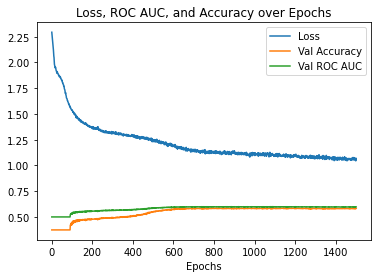

In [12]:
plt.plot(epoch_list, loss_list, label= "Loss")
plt.plot(epoch_list, acc_list, label = "Val Accuracy")
plt.plot(epoch_list, roc_list, label = "Val ROC AUC")
plt.title("Loss, ROC AUC, and Accuracy over Epochs")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [13]:
print(f'Val Accuracy last epoch: {acc_list[-1]:.4f}')
print(f'Val ROC AUC last epoch: {roc_list[-1]:.4f}')
print()
print(f'Val Accuracy at epoch 150: {acc_list[150]:.4f}')
print(f'Val ROC AUC epoch 150: {roc_list[150]:.4f}')

Val Accuracy last epoch: 0.5824
Val ROC AUC last epoch: 0.5974

Val Accuracy at epoch 150: 0.4736
Val ROC AUC epoch 150: 0.5526


In [14]:
roc_list[150]

0.5525799365020401

In [15]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(767, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 10)
)


In [16]:
model = GCN(hidden_channels=16)
# move model to gpu
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    return test_acc, roc_auc


# to calculate roc_auc, the data needs to be one hot encoded, which I am doing using LabelBinarizer()
lb = preprocessing.LabelBinarizer()
lb.fit(data.y[data.train_mask].cpu())
    
epoch_list = list()
loss_list = list()
acc_list = list()
roc_list = list()
for epoch in range(1, 3001):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    epoch_list.append(epoch)
    loss_list.append(loss.cpu().detach().numpy())
    # calculate test set accuracy
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    acc_list.append(test_acc)
    roc_auc = roc_auc_score(lb.transform(data.y[data.test_mask].cpu()),lb.transform(pred[data.test_mask].cpu()), multi_class='ovo')
    roc_list.append(roc_auc)

Epoch: 001, Loss: 2.3026
Epoch: 002, Loss: 2.2911
Epoch: 003, Loss: 2.2761
Epoch: 004, Loss: 2.2610
Epoch: 005, Loss: 2.2442
Epoch: 006, Loss: 2.2256
Epoch: 007, Loss: 2.2049
Epoch: 008, Loss: 2.1857
Epoch: 009, Loss: 2.1606
Epoch: 010, Loss: 2.1369
Epoch: 011, Loss: 2.1187
Epoch: 012, Loss: 2.0920
Epoch: 013, Loss: 2.0697
Epoch: 014, Loss: 2.0420
Epoch: 015, Loss: 2.0180
Epoch: 016, Loss: 1.9955
Epoch: 017, Loss: 1.9796
Epoch: 018, Loss: 1.9643
Epoch: 019, Loss: 1.9521
Epoch: 020, Loss: 1.9447
Epoch: 021, Loss: 1.9460
Epoch: 022, Loss: 1.9308
Epoch: 023, Loss: 1.9420
Epoch: 024, Loss: 1.9474
Epoch: 025, Loss: 1.9462
Epoch: 026, Loss: 1.9426
Epoch: 027, Loss: 1.9488
Epoch: 028, Loss: 1.9201
Epoch: 029, Loss: 1.9286
Epoch: 030, Loss: 1.9192
Epoch: 031, Loss: 1.9182
Epoch: 032, Loss: 1.9114
Epoch: 033, Loss: 1.9202
Epoch: 034, Loss: 1.9180
Epoch: 035, Loss: 1.9143
Epoch: 036, Loss: 1.9181
Epoch: 037, Loss: 1.9094
Epoch: 038, Loss: 1.9199
Epoch: 039, Loss: 1.9166
Epoch: 040, Loss: 1.9100


Epoch: 336, Loss: 1.2420
Epoch: 337, Loss: 1.2576
Epoch: 338, Loss: 1.2653
Epoch: 339, Loss: 1.2682
Epoch: 340, Loss: 1.2473
Epoch: 341, Loss: 1.2768
Epoch: 342, Loss: 1.2513
Epoch: 343, Loss: 1.2568
Epoch: 344, Loss: 1.2518
Epoch: 345, Loss: 1.2688
Epoch: 346, Loss: 1.2622
Epoch: 347, Loss: 1.2590
Epoch: 348, Loss: 1.2537
Epoch: 349, Loss: 1.2624
Epoch: 350, Loss: 1.2593
Epoch: 351, Loss: 1.2522
Epoch: 352, Loss: 1.2443
Epoch: 353, Loss: 1.2527
Epoch: 354, Loss: 1.2499
Epoch: 355, Loss: 1.2524
Epoch: 356, Loss: 1.2579
Epoch: 357, Loss: 1.2353
Epoch: 358, Loss: 1.2524
Epoch: 359, Loss: 1.2393
Epoch: 360, Loss: 1.2623
Epoch: 361, Loss: 1.2522
Epoch: 362, Loss: 1.2460
Epoch: 363, Loss: 1.2466
Epoch: 364, Loss: 1.2555
Epoch: 365, Loss: 1.2686
Epoch: 366, Loss: 1.2501
Epoch: 367, Loss: 1.2346
Epoch: 368, Loss: 1.2444
Epoch: 369, Loss: 1.2433
Epoch: 370, Loss: 1.2557
Epoch: 371, Loss: 1.2380
Epoch: 372, Loss: 1.2455
Epoch: 373, Loss: 1.2420
Epoch: 374, Loss: 1.2543
Epoch: 375, Loss: 1.2389


Epoch: 671, Loss: 1.1857
Epoch: 672, Loss: 1.1722
Epoch: 673, Loss: 1.1828
Epoch: 674, Loss: 1.1715
Epoch: 675, Loss: 1.1752
Epoch: 676, Loss: 1.1835
Epoch: 677, Loss: 1.1865
Epoch: 678, Loss: 1.1706
Epoch: 679, Loss: 1.1749
Epoch: 680, Loss: 1.1701
Epoch: 681, Loss: 1.1661
Epoch: 682, Loss: 1.1840
Epoch: 683, Loss: 1.1665
Epoch: 684, Loss: 1.1817
Epoch: 685, Loss: 1.1719
Epoch: 686, Loss: 1.1749
Epoch: 687, Loss: 1.1803
Epoch: 688, Loss: 1.1722
Epoch: 689, Loss: 1.1701
Epoch: 690, Loss: 1.1771
Epoch: 691, Loss: 1.1697
Epoch: 692, Loss: 1.1845
Epoch: 693, Loss: 1.1702
Epoch: 694, Loss: 1.1816
Epoch: 695, Loss: 1.1829
Epoch: 696, Loss: 1.1932
Epoch: 697, Loss: 1.1807
Epoch: 698, Loss: 1.1651
Epoch: 699, Loss: 1.1805
Epoch: 700, Loss: 1.1803
Epoch: 701, Loss: 1.1615
Epoch: 702, Loss: 1.1672
Epoch: 703, Loss: 1.1733
Epoch: 704, Loss: 1.1633
Epoch: 705, Loss: 1.1569
Epoch: 706, Loss: 1.1580
Epoch: 707, Loss: 1.1641
Epoch: 708, Loss: 1.1659
Epoch: 709, Loss: 1.1706
Epoch: 710, Loss: 1.1666


Epoch: 1007, Loss: 0.9303
Epoch: 1008, Loss: 0.9430
Epoch: 1009, Loss: 0.9313
Epoch: 1010, Loss: 0.9515
Epoch: 1011, Loss: 0.9421
Epoch: 1012, Loss: 0.9387
Epoch: 1013, Loss: 0.9305
Epoch: 1014, Loss: 0.9337
Epoch: 1015, Loss: 0.9163
Epoch: 1016, Loss: 0.9355
Epoch: 1017, Loss: 0.9391
Epoch: 1018, Loss: 0.9288
Epoch: 1019, Loss: 0.9261
Epoch: 1020, Loss: 0.9369
Epoch: 1021, Loss: 0.9211
Epoch: 1022, Loss: 0.9152
Epoch: 1023, Loss: 0.9192
Epoch: 1024, Loss: 0.9220
Epoch: 1025, Loss: 0.9313
Epoch: 1026, Loss: 0.9035
Epoch: 1027, Loss: 0.9144
Epoch: 1028, Loss: 0.9169
Epoch: 1029, Loss: 0.9171
Epoch: 1030, Loss: 0.9257
Epoch: 1031, Loss: 0.9243
Epoch: 1032, Loss: 0.9181
Epoch: 1033, Loss: 0.9135
Epoch: 1034, Loss: 0.9119
Epoch: 1035, Loss: 0.9187
Epoch: 1036, Loss: 0.9361
Epoch: 1037, Loss: 0.9124
Epoch: 1038, Loss: 0.9268
Epoch: 1039, Loss: 0.9206
Epoch: 1040, Loss: 0.9242
Epoch: 1041, Loss: 0.9110
Epoch: 1042, Loss: 0.9150
Epoch: 1043, Loss: 0.9084
Epoch: 1044, Loss: 0.9134
Epoch: 1045,

Epoch: 1324, Loss: 0.7731
Epoch: 1325, Loss: 0.7681
Epoch: 1326, Loss: 0.7767
Epoch: 1327, Loss: 0.7697
Epoch: 1328, Loss: 0.7725
Epoch: 1329, Loss: 0.7824
Epoch: 1330, Loss: 0.7763
Epoch: 1331, Loss: 0.7790
Epoch: 1332, Loss: 0.7737
Epoch: 1333, Loss: 0.7626
Epoch: 1334, Loss: 0.7603
Epoch: 1335, Loss: 0.7653
Epoch: 1336, Loss: 0.7640
Epoch: 1337, Loss: 0.7655
Epoch: 1338, Loss: 0.7596
Epoch: 1339, Loss: 0.7669
Epoch: 1340, Loss: 0.7769
Epoch: 1341, Loss: 0.7759
Epoch: 1342, Loss: 0.7734
Epoch: 1343, Loss: 0.7581
Epoch: 1344, Loss: 0.7612
Epoch: 1345, Loss: 0.7653
Epoch: 1346, Loss: 0.7510
Epoch: 1347, Loss: 0.7549
Epoch: 1348, Loss: 0.7495
Epoch: 1349, Loss: 0.7616
Epoch: 1350, Loss: 0.7734
Epoch: 1351, Loss: 0.7627
Epoch: 1352, Loss: 0.7633
Epoch: 1353, Loss: 0.7529
Epoch: 1354, Loss: 0.7610
Epoch: 1355, Loss: 0.7662
Epoch: 1356, Loss: 0.7694
Epoch: 1357, Loss: 0.7565
Epoch: 1358, Loss: 0.7471
Epoch: 1359, Loss: 0.7642
Epoch: 1360, Loss: 0.7568
Epoch: 1361, Loss: 0.7697
Epoch: 1362,

Epoch: 1640, Loss: 0.7210
Epoch: 1641, Loss: 0.7190
Epoch: 1642, Loss: 0.7044
Epoch: 1643, Loss: 0.7195
Epoch: 1644, Loss: 0.7264
Epoch: 1645, Loss: 0.7353
Epoch: 1646, Loss: 0.7143
Epoch: 1647, Loss: 0.7308
Epoch: 1648, Loss: 0.7240
Epoch: 1649, Loss: 0.7320
Epoch: 1650, Loss: 0.7256
Epoch: 1651, Loss: 0.7225
Epoch: 1652, Loss: 0.7293
Epoch: 1653, Loss: 0.7271
Epoch: 1654, Loss: 0.7192
Epoch: 1655, Loss: 0.7112
Epoch: 1656, Loss: 0.7104
Epoch: 1657, Loss: 0.7140
Epoch: 1658, Loss: 0.7255
Epoch: 1659, Loss: 0.7176
Epoch: 1660, Loss: 0.7240
Epoch: 1661, Loss: 0.7125
Epoch: 1662, Loss: 0.7200
Epoch: 1663, Loss: 0.7077
Epoch: 1664, Loss: 0.7196
Epoch: 1665, Loss: 0.7143
Epoch: 1666, Loss: 0.7124
Epoch: 1667, Loss: 0.7047
Epoch: 1668, Loss: 0.7173
Epoch: 1669, Loss: 0.7134
Epoch: 1670, Loss: 0.7116
Epoch: 1671, Loss: 0.7139
Epoch: 1672, Loss: 0.7243
Epoch: 1673, Loss: 0.7214
Epoch: 1674, Loss: 0.7151
Epoch: 1675, Loss: 0.7261
Epoch: 1676, Loss: 0.7225
Epoch: 1677, Loss: 0.7294
Epoch: 1678,

Epoch: 1956, Loss: 0.6766
Epoch: 1957, Loss: 0.6689
Epoch: 1958, Loss: 0.6745
Epoch: 1959, Loss: 0.6693
Epoch: 1960, Loss: 0.6818
Epoch: 1961, Loss: 0.6737
Epoch: 1962, Loss: 0.6610
Epoch: 1963, Loss: 0.6664
Epoch: 1964, Loss: 0.6634
Epoch: 1965, Loss: 0.6642
Epoch: 1966, Loss: 0.6700
Epoch: 1967, Loss: 0.6618
Epoch: 1968, Loss: 0.6682
Epoch: 1969, Loss: 0.6544
Epoch: 1970, Loss: 0.6646
Epoch: 1971, Loss: 0.6690
Epoch: 1972, Loss: 0.6504
Epoch: 1973, Loss: 0.6668
Epoch: 1974, Loss: 0.6586
Epoch: 1975, Loss: 0.6681
Epoch: 1976, Loss: 0.6662
Epoch: 1977, Loss: 0.6721
Epoch: 1978, Loss: 0.6727
Epoch: 1979, Loss: 0.6674
Epoch: 1980, Loss: 0.6644
Epoch: 1981, Loss: 0.6601
Epoch: 1982, Loss: 0.6567
Epoch: 1983, Loss: 0.6623
Epoch: 1984, Loss: 0.6541
Epoch: 1985, Loss: 0.6609
Epoch: 1986, Loss: 0.6689
Epoch: 1987, Loss: 0.6691
Epoch: 1988, Loss: 0.6795
Epoch: 1989, Loss: 0.6648
Epoch: 1990, Loss: 0.6602
Epoch: 1991, Loss: 0.6610
Epoch: 1992, Loss: 0.6499
Epoch: 1993, Loss: 0.6651
Epoch: 1994,

Epoch: 2280, Loss: 0.6267
Epoch: 2281, Loss: 0.6173
Epoch: 2282, Loss: 0.6248
Epoch: 2283, Loss: 0.6152
Epoch: 2284, Loss: 0.6255
Epoch: 2285, Loss: 0.6212
Epoch: 2286, Loss: 0.6147
Epoch: 2287, Loss: 0.6110
Epoch: 2288, Loss: 0.6185
Epoch: 2289, Loss: 0.6176
Epoch: 2290, Loss: 0.6163
Epoch: 2291, Loss: 0.6139
Epoch: 2292, Loss: 0.6204
Epoch: 2293, Loss: 0.6189
Epoch: 2294, Loss: 0.6209
Epoch: 2295, Loss: 0.6314
Epoch: 2296, Loss: 0.6082
Epoch: 2297, Loss: 0.6330
Epoch: 2298, Loss: 0.6163
Epoch: 2299, Loss: 0.6135
Epoch: 2300, Loss: 0.6236
Epoch: 2301, Loss: 0.6215
Epoch: 2302, Loss: 0.6183
Epoch: 2303, Loss: 0.6163
Epoch: 2304, Loss: 0.6175
Epoch: 2305, Loss: 0.6220
Epoch: 2306, Loss: 0.6037
Epoch: 2307, Loss: 0.6102
Epoch: 2308, Loss: 0.6130
Epoch: 2309, Loss: 0.6093
Epoch: 2310, Loss: 0.6209
Epoch: 2311, Loss: 0.6109
Epoch: 2312, Loss: 0.6139
Epoch: 2313, Loss: 0.6283
Epoch: 2314, Loss: 0.6167
Epoch: 2315, Loss: 0.6112
Epoch: 2316, Loss: 0.5949
Epoch: 2317, Loss: 0.6043
Epoch: 2318,

Epoch: 2598, Loss: 0.5920
Epoch: 2599, Loss: 0.6008
Epoch: 2600, Loss: 0.6002
Epoch: 2601, Loss: 0.5839
Epoch: 2602, Loss: 0.6135
Epoch: 2603, Loss: 0.5862
Epoch: 2604, Loss: 0.5912
Epoch: 2605, Loss: 0.6013
Epoch: 2606, Loss: 0.6018
Epoch: 2607, Loss: 0.6008
Epoch: 2608, Loss: 0.5885
Epoch: 2609, Loss: 0.6000
Epoch: 2610, Loss: 0.5881
Epoch: 2611, Loss: 0.6028
Epoch: 2612, Loss: 0.5919
Epoch: 2613, Loss: 0.5810
Epoch: 2614, Loss: 0.5843
Epoch: 2615, Loss: 0.5860
Epoch: 2616, Loss: 0.5895
Epoch: 2617, Loss: 0.6005
Epoch: 2618, Loss: 0.5923
Epoch: 2619, Loss: 0.6118
Epoch: 2620, Loss: 0.5920
Epoch: 2621, Loss: 0.6100
Epoch: 2622, Loss: 0.5934
Epoch: 2623, Loss: 0.6023
Epoch: 2624, Loss: 0.5939
Epoch: 2625, Loss: 0.6079
Epoch: 2626, Loss: 0.5916
Epoch: 2627, Loss: 0.6004
Epoch: 2628, Loss: 0.6016
Epoch: 2629, Loss: 0.5913
Epoch: 2630, Loss: 0.5792
Epoch: 2631, Loss: 0.5945
Epoch: 2632, Loss: 0.5959
Epoch: 2633, Loss: 0.6067
Epoch: 2634, Loss: 0.5930
Epoch: 2635, Loss: 0.6090
Epoch: 2636,

Epoch: 2915, Loss: 0.5771
Epoch: 2916, Loss: 0.5779
Epoch: 2917, Loss: 0.5714
Epoch: 2918, Loss: 0.5891
Epoch: 2919, Loss: 0.5813
Epoch: 2920, Loss: 0.5894
Epoch: 2921, Loss: 0.5798
Epoch: 2922, Loss: 0.5853
Epoch: 2923, Loss: 0.5795
Epoch: 2924, Loss: 0.5807
Epoch: 2925, Loss: 0.5869
Epoch: 2926, Loss: 0.5751
Epoch: 2927, Loss: 0.5672
Epoch: 2928, Loss: 0.5642
Epoch: 2929, Loss: 0.5775
Epoch: 2930, Loss: 0.5730
Epoch: 2931, Loss: 0.5828
Epoch: 2932, Loss: 0.5967
Epoch: 2933, Loss: 0.5802
Epoch: 2934, Loss: 0.5781
Epoch: 2935, Loss: 0.5775
Epoch: 2936, Loss: 0.5787
Epoch: 2937, Loss: 0.5966
Epoch: 2938, Loss: 0.5667
Epoch: 2939, Loss: 0.5682
Epoch: 2940, Loss: 0.5695
Epoch: 2941, Loss: 0.5777
Epoch: 2942, Loss: 0.5835
Epoch: 2943, Loss: 0.5752
Epoch: 2944, Loss: 0.5787
Epoch: 2945, Loss: 0.5864
Epoch: 2946, Loss: 0.5664
Epoch: 2947, Loss: 0.5843
Epoch: 2948, Loss: 0.5852
Epoch: 2949, Loss: 0.5975
Epoch: 2950, Loss: 0.5673
Epoch: 2951, Loss: 0.5861
Epoch: 2952, Loss: 0.5843
Epoch: 2953,

Below I can see that with the GNN, the model ROC AUC continues to increase for far longer than with the MLP model. It is able to utilize much more data since it has access to the edges and it is able to use that information to achieve a much higher accuracy score. The performance of the GNN doesn't level off until around epoch 1500.

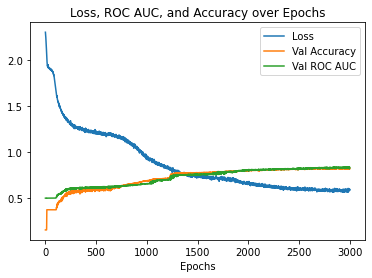

In [17]:
plt.plot(epoch_list, loss_list, label= "Loss")
plt.plot(epoch_list, acc_list, label = "Val Accuracy")
plt.plot(epoch_list, roc_list, label = "Val ROC AUC")
plt.title("Loss, ROC AUC, and Accuracy over Epochs")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [18]:
print(f'Val Accuracy last epoch: {acc_list[-1]:.4f}')
print(f'Val ROC AUC last epoch: {roc_list[-1]:.4f}')
print()
print(f'Val Accuracy at epoch 1500: {acc_list[1500]:.4f}')
print(f'Val ROC AUC epoch 1500: {roc_list[1500]:.4f}')

Val Accuracy last epoch: 0.8240
Val ROC AUC last epoch: 0.8342

Val Accuracy at epoch 1500: 0.7764
Val ROC AUC epoch 1500: 0.7597
